# Imports

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 

Mounted at /gdrive
/gdrive


In [2]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [3]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import numpy as np
import pandas as pd 

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.python.keras.layers.pooling import AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K
from keras import regularizers
from tensorflow.python.keras.utils import plot_model 

sys.path.append(".")
import utils
from utils import *

l2_lam = 5e-07 
l1_lam = 1e-08 

TensorFlow 1.x selected.


Using TensorFlow backend.


# Paths

In [4]:
zhou_models_folder="./models/zhou"
bian_models_folder="./models/bian"

bian_data = r"dataset/bian_crc01_pmds.pkl"
zhou_data = r"dataset/zhou_pmds.pkl"

# Get heatmap for density < 4

In [5]:
import pandas as pd 
import numpy as np
from utils import *


In [6]:
data = pd.read_pickle(zhou_data)
test_data = data[data["orig_meth"] > 0.5]
test_data["ccpg"] = test_data["sequence"].str.count("CG")
test_data =  test_data[test_data["ccpg"] <=3]
X_test_seq = np.array([seq_to_mat(seq) for seq in test_data["sequence"]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
zhou_models = load_models(zhou_models_folder)
zhou_pred =  predict(zhou_models, X_test_seq)
test_data["zhou_pred"] = zhou_pred

bian_models = load_models(bian_models_folder)
bian_y_pred =  predict(bian_models, X_test_seq)
test_data["bian_pred"] = bian_y_pred

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


No handles with labels found to put in legend.


<Figure size 1200x800 with 0 Axes>

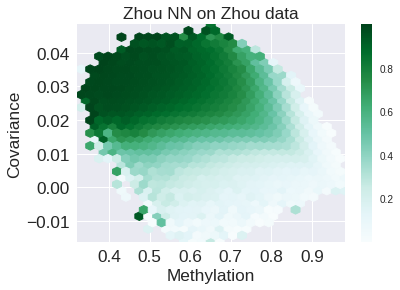

In [8]:
f = plt.figure(1, dpi=200)
test_data.plot.hexbin(x='meth', y='coveriance', C='zhou_pred', reduce_C_function=np.mean, gridsize=30, sharex=False,ylim=(test_data["coveriance"].min(), test_data["coveriance"].max()), xlim=(test_data["meth"].min(), test_data["meth"].max()))
plt.title("Zhou NN on Zhou data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("Covariance", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(fontsize="xx-large")
f.savefig("sup2_c_left.pdf", bbox_inches='tight')

No handles with labels found to put in legend.


<Figure size 7200x4800 with 0 Axes>

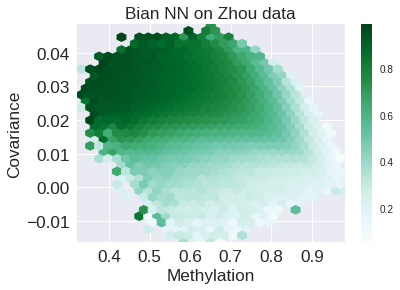

In [9]:
f = plt.figure(1, dpi=1200)
test_data.plot.hexbin(x='meth', y='coveriance', C='bian_pred', reduce_C_function=np.mean, gridsize=30, sharex=False,ylim=(test_data["coveriance"].min(), test_data["coveriance"].max()), xlim=(test_data["meth"].min(), test_data["meth"].max()))
plt.title("Bian NN on Zhou data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("Covariance", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(fontsize="xx-large")
f.savefig("sup2_c_right.pdf", bbox_inches='tight')

In [10]:
data = pd.read_pickle(bian_data)
test_data = data[data["orig_meth"] > 0.5]
test_data["ccpg"] = test_data["sequence"].str.count("CG")
test_data =  test_data[test_data["ccpg"] <=3]

X_test_seq = np.array([seq_to_mat(seq) for seq in test_data["sequence"]])
zhou_models = load_models(zhou_models_folder)
zhou_pred =  predict(zhou_models, X_test_seq)
test_data["zhou_pred"] = zhou_pred

bian_models = load_models(bian_models_folder)
bian_y_pred =  predict(bian_models, X_test_seq)
test_data["bian_pred"] = bian_y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


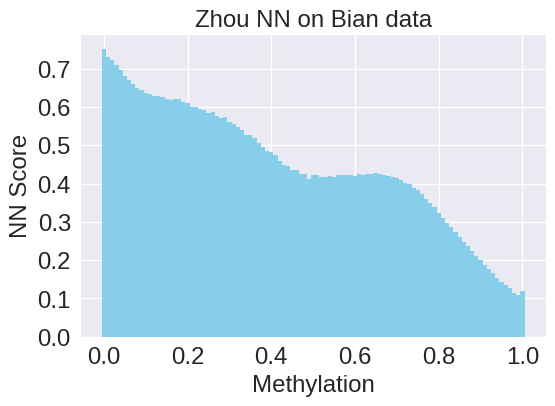

In [11]:
x = np.arange(0,1.01,0.01)
y_zhou_pred = []
y_bian_pred = []
for i in x:
    temp_df = test_data[np.logical_and(test_data["meth"] >=i, test_data["meth"]<i+0.01)]
    y_zhou_pred.append(np.mean(temp_df["zhou_pred"]))
    y_bian_pred.append(np.mean(temp_df["bian_pred"]))

f = plt.figure(1, dpi=100)
plt.bar(x,y_zhou_pred, width=0.01, color="skyblue")
plt.title("Zhou NN on Bian data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("NN Score", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
f.savefig("sup2_d_left.pdf", bbox_inches='tight')

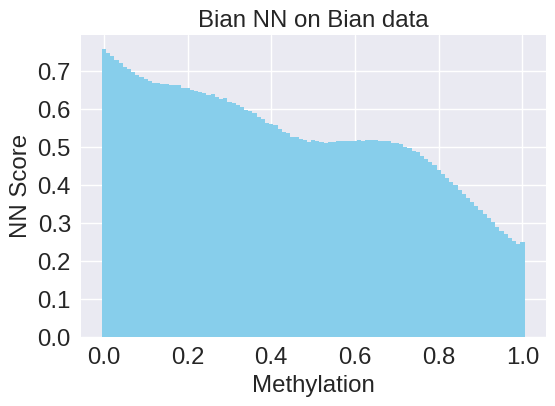

In [12]:

plt.figure(1, dpi=100)
plt.bar(x,y_bian_pred, width=0.01, color="skyblue")
plt.title("Bian NN on Bian data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("NN Score", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
f.savefig("sup2_d_right.pdf", bbox_inches='tight')


# Get heatmap for density > 3

In [13]:
import pandas as pd 
import numpy as np
from utils import *


In [14]:
data = pd.read_pickle(zhou_data)
test_data = data[data["orig_meth"] > 0.5]
test_data["ccpg"] = test_data["sequence"].str.count("CG")
test_data =  test_data[test_data["ccpg"] > 3]
X_test_seq = np.array([seq_to_mat(seq) for seq in test_data["sequence"]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
zhou_models = load_models(zhou_models_folder)
zhou_pred =  predict(zhou_models, X_test_seq)
test_data["zhou_pred"] = zhou_pred

bian_models = load_models(bian_models_folder)
bian_y_pred =  predict(bian_models, X_test_seq)
test_data["bian_pred"] = bian_y_pred

No handles with labels found to put in legend.


<Figure size 1200x800 with 0 Axes>

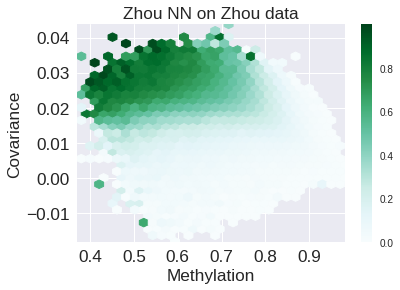

In [16]:
f = plt.figure(1, dpi=200)
test_data.plot.hexbin(x='meth', y='coveriance', C='zhou_pred', reduce_C_function=np.mean, gridsize=30, sharex=False,ylim=(test_data["coveriance"].min(), test_data["coveriance"].max()), xlim=(test_data["meth"].min(), test_data["meth"].max()))
plt.title("Zhou NN on Zhou data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("Covariance", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(fontsize="xx-large")
f.savefig("sup2_f_left.pdf", bbox_inches='tight')

No handles with labels found to put in legend.


<Figure size 7200x4800 with 0 Axes>

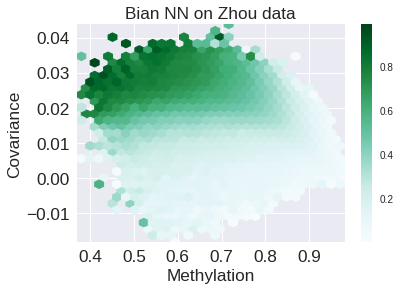

In [17]:
f = plt.figure(1, dpi=1200)
test_data.plot.hexbin(x='meth', y='coveriance', C='bian_pred', reduce_C_function=np.mean, gridsize=30, sharex=False,ylim=(test_data["coveriance"].min(), test_data["coveriance"].max()), xlim=(test_data["meth"].min(), test_data["meth"].max()))
plt.title("Bian NN on Zhou data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("Covariance", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.legend(fontsize="xx-large")
f.savefig("sup2_f_right.pdf", bbox_inches='tight')

In [18]:
data = pd.read_pickle(bian_data)
test_data = data[data["orig_meth"] > 0.5]
test_data["ccpg"] = test_data["sequence"].str.count("CG")
test_data =  test_data[test_data["ccpg"] > 3]

X_test_seq = np.array([seq_to_mat(seq) for seq in test_data["sequence"]])
zhou_models = load_models(zhou_models_folder)
zhou_pred =  predict(zhou_models, X_test_seq)
test_data["zhou_pred"] = zhou_pred

bian_models = load_models(bian_models_folder)
bian_y_pred =  predict(bian_models, X_test_seq)
test_data["bian_pred"] = bian_y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


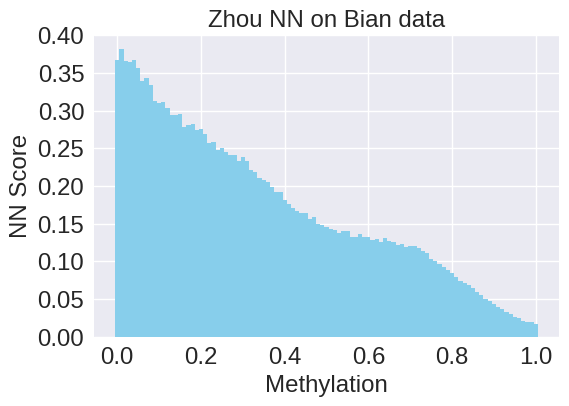

In [19]:
x = np.arange(0,1.01,0.01)
y_zhou_pred = []
y_bian_pred = []
for i in x:
    temp_df = test_data[np.logical_and(test_data["meth"] >=i, test_data["meth"]<i+0.01)]
    y_zhou_pred.append(np.mean(temp_df["zhou_pred"]))
    y_bian_pred.append(np.mean(temp_df["bian_pred"]))

f = plt.figure(1, dpi=100)
plt.bar(x,y_zhou_pred, width=0.01, color="skyblue")
plt.title("Zhou NN on Bian data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("NN Score", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
f.savefig("sup2_g_left.pdf", bbox_inches='tight')

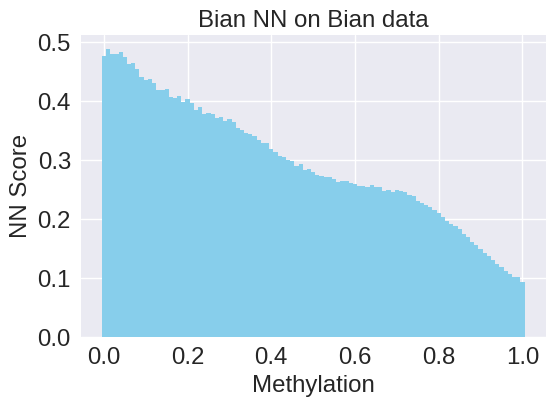

In [20]:

f = plt.figure(1, dpi=100)
plt.bar(x,y_bian_pred, width=0.01, color="skyblue")
plt.title("Bian NN on Bian data", fontsize="xx-large")
plt.xlabel("Methylation", fontsize="xx-large")
plt.ylabel("NN Score", fontsize="xx-large")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
f.savefig("sup2_g_right.pdf", bbox_inches='tight')

#Games

In [ ]:
data = pd.read_pickle(bian_data)


In [ ]:
data["ccpg"] = data["sequence"].str.count("CG")

In [ ]:
np.sum(data["ccpg"] < 4) / data.shape[0]

0.6944353398217524